In [ ]:
# default_exp data.core 

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [ ]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [ ]:
# hide
# just check previous nb still works. Sometimes import errors
horizon,lookback = 2,5
ints = L(np.arange(7)[None,:],np.arange(7,15)[None,:],np.arange(15,25)[None,:]).map(tensor)
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=2)
test_eq(dl.n, len(dl._ids))
test_eq(dl.n, 7)
test_eq(len(dl),4)    

for o in dl:pass

# TSDataLoaders

## Utils

In [ ]:
# export 
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [ ]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [ ]:
# export 
def make_test(items:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the every ts in `items` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.
    
    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = L(), L()
    for ts in items:        
        val.append(ts[:, -(horizon+lookback):])
        if keep_lookback:
            train.append(ts[:, :-(horizon)])
        else:
            train.append(ts[:, :-(horizon+lookback)])
            
    return train, val

def make_test_pct(items:L(), pct:float):
    """Splits the every ts in `items` based on `pct`(percentage) of the length of the timeserie, where the last part will go into `val` and the first in `train`.
    
    """
    train, val = L(), L()
    for ts in items:        
        split_idx = int((1-pct)*ts.shape[1])   
        train.append(ts[:,:split_idx])
        val.append(ts[:,split_idx:])
            
    return train, val

In [ ]:
a = [np.random.randn(3,15)]*50
train, val = make_test(a,5,5)
test_eq(train[0],a[0][:,:-10])
test_eq(val[0],a[0][:,-10:])

train, val = make_test(a,5,5,True)
test_eq(train[0],a[0][:,:-5])
test_eq(val[0],a[0][:,-10:])

## Dataloaders

In [ ]:
#export
class TSDataLoaders(DataLoaders):
    @classmethod
    @delegates(TSDataLoader.__init__)
    def from_folder(cls, data_path:Path, valid_pct=.5, seed=None, horizon=None, lookback=None, step=1,
                   nrows=None, skiprows=None, incl_test = True, path:Path='.', device=None, **kwargs):
        """Create from M-compition style in `path` with `train`,`test` csv-files. 
        
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        train, test = get_ts_files(data_path, nrows=nrows, skiprows=skiprows)
        items = concat_ts_list(train, test).map(tensor)
        horizon = ifnone(horizon, len(test[0]))
        lookback = ifnone(lookback, horizon * 3)
        return cls.from_items(items, horizon, lookback = lookback,  step = step, incl_test=incl_test, path=path, device=device, **kwargs)


    @classmethod
    @delegates(TSDataLoader.__init__)
    def from_items(cls, items:L, horizon:int, valid_pct=.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, **kwargs):
        """Create an list of time series. 

        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        if incl_test:
            items, test = make_test(items, horizon, lookback, keep_lookback = True)
        train, valid = make_test(items, int(lookback*valid_pct), lookback, keep_lookback = True)
        
        db = DataLoaders(*[TSDataLoader(items, horizon=horizon, lookback=lookback, step=step, **kwargs) for items in [train,valid]], path=path, device=device)
        if device is None:
            db.cuda()
        if incl_test:
            db.test = TSDataLoader(test, horizon=horizon, lookback=lookback, step=step)
            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")
#         TODO add with test_dl, currently give buges 
        return db 

In [ ]:
# hide
# from fastseq.data.external import *
horizon,lookback = 2,5
items = L(np.arange(9)[None,:],np.arange(9,18)[None,:],np.arange(18,27)[None,:]).map(tensor)
dbunch = TSDataLoaders.from_items(items, horizon=horizon, lookback = lookback, incl_test=False)

for o in dbunch[0].one_batch():
    test_eq(o[0].is_cuda, True)

Train:3; Valid: 3


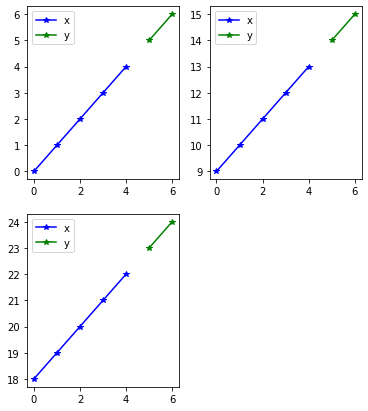

In [ ]:
# hide
dbunch.show_batch(max_n=6)

In [ ]:
# hide
# from fastseq.data.external import *
# from fastai2.basics import *
path = untar_data(URLs.m4_daily)
path.ls()

dbunch = TSDataLoaders.from_folder(path, horizon = 14, step=5, bs=64, nrows=10)
for o in dbunch.train.one_batch():
    test_eq(o.is_cuda, True)
    break
for o in dbunch.valid:
    test_eq(o[0].is_cuda, True)
    break

Train:1280; Valid: 20; Test 10


In [ ]:
# hide
dbunch = TSDataLoaders.from_folder(path, horizon = 14, step=5, bs=64, nrows=10, device = 'cpu')
for o in dbunch.train:
    test_eq(o[0].is_cuda, False)
    break
for o in dbunch.valid:
    test_eq(o[0].is_cuda, False)
    break
    

Train:1280; Valid: 20; Test 10


In [ ]:
# hide
test_eq(dbunch.train.n,1280)
test_eq(dbunch.valid.n,20)
test_eq(dbunch.test.n,10)

In [ ]:
# hide
dl = dbunch.new(shuffle=True)

In [ ]:
show_doc(TSDataLoaders.from_items, name='TSDataLoaders.from_items')

<h4 id="TSDataLoaders.from_items" class="doc_header"><code>TSDataLoaders.from_items</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>TSDataLoaders.from_items</code>(**`items`**:`L`, **`horizon`**:`int`, **`valid_pct`**=*`0.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series. 

The `DataLoader` for the test set will be save as an attribute under `test_dl`

In [ ]:
show_doc(TSDataLoaders.from_folder, name='TSDataLoaders.from_folder')

<h4 id="TSDataLoaders.from_folder" class="doc_header"><code>TSDataLoaders.from_folder</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>TSDataLoaders.from_folder</code>(**`data_path`**:`Path`, **`valid_pct`**=*`0.5`*, **`seed`**=*`None`*, **`horizon`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`nrows`**=*`None`*, **`skiprows`**=*`None`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create from M-compition style in `path` with `train`,`test` csv-files. 

The `DataLoader` for the test set will be save as an attribute under `test_dl`

Train:9672; Valid: 200; Test 100


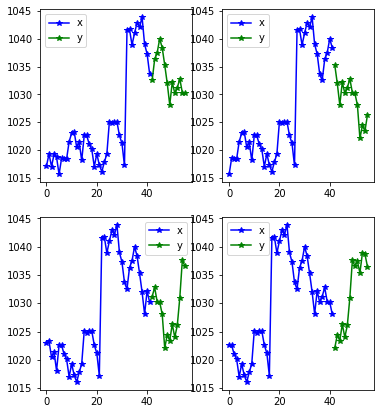

In [ ]:
dbunch = TSDataLoaders.from_folder(path, horizon = 14, step=5, bs=64, nrows=100)
dbunch.train.show_batch(max_n=4)

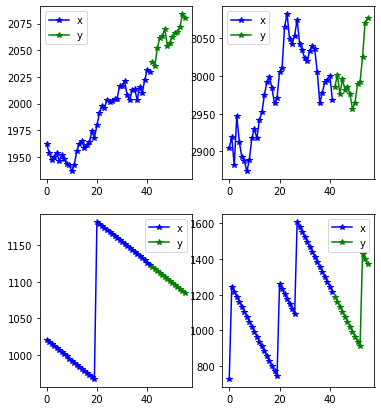

In [ ]:
dbunch.test.show_batch(max_n=4)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_data.transforms.ipynb.
Converted 04_metrics.ipynb.
Converted 05_models.nbeats.ipynb.
Converted 07_interpret.ipynb.
Converted 100_readme_alt.ipynb.
Converted 21_data.loadpandas.ipynb.
Converted index.ipynb.
